使用最小二乘对抗生成网络生成AnimateFace数据
===

# 1.全局设置

In [15]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
import jjzhk.progressbar as bar

DATA_PATH = "/input/AnimateFace"
EPOCH = 100
GPU_NUMS = 1
BATCH_SIZE = 64
NOISE_DIM  = 100
IMAGE_CHANNEL = 3
IMAGE_SIZE = 96
LEARNING_RATE = 2e-4


In [16]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, torch.nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, torch.nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, torch.nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

# 2.模型

In [17]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(NOISE_DIM, 512 * 3 * 3),
            torch.nn.BatchNorm1d(512 * 3 * 3),
            torch.nn.ReLU()
        )

        self.deconv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(512, 256, 4, 2, 1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU()
        )

        self.deconv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, 128, 4, 2, 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU()
        )

        self.deconv3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 64, 4, 2, 1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )

        self.deconv4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 32, 4, 2, 1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )

        self.deconv5 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(32, IMAGE_CHANNEL, 4, 2, 1),
            torch.nn.Sigmoid()
        )
        initialize_weights(self)

    def forward(self, x):
        output = self.fc1(x)
        output = output.view(-1, 512, 3, 3)
        output = self.deconv1(output)
        output = self.deconv2(output)
        output = self.deconv3(output)
        output = self.deconv4(output)
        output = self.deconv5(output)
        return output


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(IMAGE_CHANNEL, 32, 4, 2, 1),
            torch.nn.LeakyReLU(0.2)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 4, 2, 1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2)
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 4, 2, 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2)
        )

        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, 4, 2, 1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2)
        )

        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, 4, 2, 1),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2)
        )

        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(512 * 3 * 3, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.LeakyReLU(0.2)
        )

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(1024, 1),
            torch.nn.Sigmoid()
        )

        initialize_weights(self)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.conv5(output)
        output = output.view(-1, 512 * 3 * 3)
        output = self.fc1(output)
        output = self.fc2(output)

        return output

# 3.导入数据

In [18]:
NetD = Discriminator()
NetG = Generator()
MSE_LOSS = torch.nn.MSELoss()

optimizerD = torch.optim.Adam(NetD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(NetG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
dataset = tv.datasets.ImageFolder(root=DATA_PATH,transform=tv.transforms.Compose([
    tv.transforms.ToTensor(),
]))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

fix_noise = torch.randn(100, NOISE_DIM)
fix_noise_var = torch.autograd.Variable(fix_noise)

if torch.cuda.is_available() > 0:
    NetG = NetG.cuda()
    NetD = NetD.cuda()
    MSE_LOSS = MSE_LOSS.cuda()
    fix_noise_var = fix_noise_var.cuda()


# 4.训练

In [20]:
showbar = bar.ProgressBar(EPOCH, len(train_loader), "D Loss:%.3f;G Loss:%.3f")
for epoch in range(1, EPOCH + 1):
    NetG.train()
    for index, (image, label) in enumerate(train_loader):
        mini_batch = image.shape[0]

        noise = torch.rand(mini_batch, NOISE_DIM)

        label_real = torch.ones( mini_batch, 1)
        label_fake = torch.zeros(mini_batch, 1)
        real_var  = torch.autograd.Variable(image)
        noise_var = torch.autograd.Variable(noise)
        label_real_var = torch.autograd.Variable(label_real)
        label_fake_var = torch.autograd.Variable(label_fake)

        if torch.cuda.is_available():
            real_var = real_var.cuda()
            noise_var = noise_var.cuda()
            label_real_var = label_real_var.cuda()
            label_fake_var = label_fake_var.cuda()

        NetD.zero_grad()

        D_real = NetD(real_var)
        D_real_loss = MSE_LOSS(D_real, label_real_var)

        G_ = NetG(noise_var)
        D_fake = NetD(G_)
        D_fake_loss = MSE_LOSS(D_fake, label_fake_var)

        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        optimizerD.step()

        NetG.zero_grad()

        G_ = NetG(noise_var)
        D_fake = NetD(G_)
        G_loss = MSE_LOSS(D_fake, label_real_var)

        G_loss.backward()
        optimizerG.step()

        showbar.show(epoch, D_loss.item(), G_loss.item())

Epoch:1 / 100 [****************************************************************************************************] 801 / 801 ,D Loss:0.365;G Loss:0.637,total=0:02:550
Epoch:2 / 100 [****************************************************************************************************] 801 / 801 ,D Loss:0.361;G Loss:0.743,total=0:02:570:07:12
Epoch:3 / 100 [****************************************************************************************************] 801 / 801 ,D Loss:0.248;G Loss:0.853,total=0:02:57010:229
Epoch:4 / 100 [****************************************************************************************************] 801 / 801 ,D Loss:0.141;G Loss:0.864,total=0:02:56027:2842
Epoch:5 / 100 [****************************************************************************************************] 801 / 801 ,D Loss:0.308;G Loss:0.879,total=0:02:56005:4705
Epoch:6 / 100 [****************************************************************************************************] 801 / 801 ,D

Epoch:48 / 100 [****************************************************************************************************] 801 / 801 ,D Loss:0.045;G Loss:0.978,total=0:02:560218:3726
Epoch:49 / 100 [****************************************************************************************************] 801 / 801 ,D Loss:0.051;G Loss:0.964,total=0:02:560804:0596
Epoch:50 / 100 [****************************************************************************************************] 801 / 801 ,D Loss:0.235;G Loss:0.995,total=0:02:550011:4829
Epoch:51 / 100 [****************************************************************************************************] 801 / 801 ,D Loss:0.064;G Loss:0.993,total=0:02:560418:5905
Epoch:52 / 100 [****************************************************************************************************] 801 / 801 ,D Loss:0.044;G Loss:0.985,total=0:02:560904:5318
Epoch:53 / 100 [**********************************************************************************************

Epoch:94 / 100 [****************************************************************************************************] 801 / 801 ,D Loss:0.000;G Loss:0.999,total=0:02:5707:11:5952
Epoch:95 / 100 [****************************************************************************************************] 801 / 801 ,D Loss:0.001;G Loss:0.998,total=0:02:5505:00:4263
Epoch:96 / 100 [****************************************************************************************************] 801 / 801 ,D Loss:0.056;G Loss:0.992,total=0:02:5505:02:3278
Epoch:97 / 100 [****************************************************************************************************] 801 / 801 ,D Loss:0.056;G Loss:0.997,total=0:02:5606:04:2209
Epoch:98 / 100 [****************************************************************************************************] 801 / 801 ,D Loss:0.006;G Loss:0.986,total=0:02:5607:06:1447
Epoch:99 / 100 [*****************************************************************************************

# 5.生成

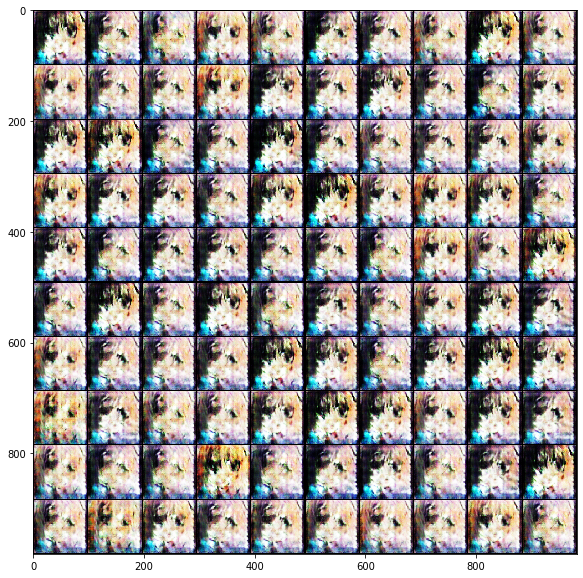

In [21]:
fake_u=NetG(fix_noise_var)
img = tv.utils.make_grid(fake_u.data, nrow=10, normalize=True)
plt.figure(figsize=(10,10), facecolor='w')
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))